# generic scikit-learn classifier

run any scikit-learn compatible classifier or list of classifiers

## steps
1. **generate a scikit-learn model configuration** using the `model_pkg_class` parameter
   * input a package and class name, for example, `sklearn.linear_model.LogisticRegression`  
   * mlrun will find the class and instantiate a copy using default parameters  
   * You can modify both the model class instantiator and the fit methods  (other functions could be similarly modified)
2. **get a sample of data** from a data source
   * select all rows using -1
   * select a random sample of rows using a negative integer
   * select consecutive rows using a positive integer
3. **split the data** into train, validation, and test sets 
   * the test set is saved as an artifact and never seen again until testing
   * WIP: this will be parametrized to produce cross-validator splits (one way of performing CV)
4. **train the model** using xgboost in one of its flavours (dask, gpu, mpi...)
5. **pickle / serialize the model**
   * models can be pickled or saved as json (a newer xgboost format)
6. **evaluate the model**
   * a custom evaluator can be provided, see function doc for details

In [1]:
# nuclio: ignore
import nuclio

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import json
import os

from cloudpickle import dumps, load, dump

from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics

from typing import List
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact

import mlutils
from mlutils import (get_sample, get_splits,
                     gen_sklearn_model, create_class,
                     eval_class_model, log_model)

def train_model(
    context: MLClientCtx,
    model_pkg_class: str,
    dataset: DataItem,
    label_column: str = "labels",
    encode_cols: List[str] = [],
    sample: int = -1,
    test_size: float = 0.30,
    train_val_split: float = 0.75,
    test_set_key: str = "test_set",
    model_evaluator = None,
    models_dest: str = "",
    plots_dest: str = "",
    file_ext: str = "parquet",
    model_pkg_file: str = "",
    random_state: int = 1,
) -> None:
    """train a classifier
    
    An optional cutom model evaluator can be supplied that should have the signature:
    `my_custom_evaluator(context, xvalid, yvalid, model)` and return a dictionary of 
    scalar "results", a "plots" keys with a list of PlotArtifacts, and 
    and "tables" key containing a returned list of TableArtifacts.
    
    :param context:           the function context
    :param model_pkg_class:   the model to train, e.g, "sklearn.neural_networks.MLPClassifier", 
                              or json model config
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param test_size:         (0.05) test set size
    :param train_val_split:   (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param test_set_key:      key of held out data in artifact store
    :param model_evaluator:   (None) a custom model evaluator can be specified
    :param models_dest:       ("") models subfolder on artifact path
    :param plots_dest:        ("") plot subfolder on artifact path
    :param file_ext:          ("parquet") format for test_set_key hold out data
    :param random_state:      (1) sklearn rng seed

    """
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)
    
    # split the sample into train, validate, and test sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = \
        get_splits(raw, labels, 3, test_size, 1-train_val_split, random_state)
    
    # set aside some test data
    context.log_dataset(test_set_key, 
                        df=pd.concat([xtest, ytest.to_frame()], axis=1),
                        format=file_ext, index=False, 
                        labels={"data-type": "held-out"})

    # generate a model configuration and add CLASS and FIT params:
    model_config = gen_sklearn_model(model_pkg_class,
                                     context.parameters.items())

    # update FIT params with features and labels:
    model_config["FIT"].update({"X": xtrain,
                                "y": ytrain.values})
    
    # generate a scikit-learn class:
    ClassifierClass = create_class(model_config["META"]["class"])
    
    # instantiate the class with our updated CLASS params:
    model = ClassifierClass(**model_config["CLASS"])
    
    # and run `fit` with our updated FIT params:
    model.fit(**model_config["FIT"])
    
    # evaluate model:
    if model_evaluator:
        eval_metrics = model_evaluator(context, xvalid, yvalid, model)
    else:
        eval_metrics = eval_class_model(context, xvalid, yvalid, model)
        
    # log it all:
    log_model(context, dumps(model), eval_metrics, plots_dest, models_dest)

In [3]:
# nuclio: end-code

### sklearn trainer setup

the following task paramaters are common to all runs

In [4]:
task_params = {
    "name" : "task sklearn classifier",
    "params" : {
        "sample"             : -1,
        "test_size"          : 0.30,
        "train_val_split"    : 0.75,
        "random_state"       : 1,
        "n_jobs"             : -1,
        "plots_dest"         : "plots-p",
        "models_dest"        : 'sklearn-clfmodel'}}

models = [
    "sklearn.ensemble.RandomForestClassifier", 
    "sklearn.linear_model.LogisticRegression",
    "sklearn.ensemble.AdaBoostClassifier"
]

### set model parameters and run locally

* loop over a list of candidate models, update the task and run a local trainer for that model  
* optionally customize some parameters for each model
* accumulate the resulting artifacts in a list of dicts for debugging and testing purposes  

please note that the following parameters have been chosen without regard to optimization and model tuning

In [5]:
from mlrun import mlconf

DATA_REPO = "https://raw.githubusercontent.com/yjb-ds/testdata/master/" 

# choose a binary or multiclass dataset
#DATA_PATH = "sklearn_classfier/iris_dataset.csv" # MULTICLASS
DATA_PATH = "data/clf-k2-m24-n10k-bal.csv" # MULTICLASS

DATA_URL = f"{DATA_REPO}/{DATA_PATH}"

[mlrun] 2020-05-31 16:16:57,937 starting run sklearn_ensemble_RandomForestClassifier uid=f27fbfe88c6046a4a433f81d309a9a1b  -> http://mlrun-api:8080
[mlrun] 2020-05-31 16:16:59,059 log artifact test_set at /User/artifacts/test_set.parquet, size: 700819, db: Y
MULTICLASS False
[mlrun] 2020-05-31 16:17:00,412 log artifact calibration curve at /User/artifacts/ppp/calibration curve.html, size: 25688, db: Y
[mlrun] 2020-05-31 16:17:00,432 log artifact confusion-matrix-normalized at /User/artifacts/ppp/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-31 16:17:00,458 log artifact feature-importances at /User/artifacts/ppp/feature-importances.html, size: 1758, db: Y
[mlrun] 2020-05-31 16:17:00,526 log artifact roc-binary at /User/artifacts/ppp/roc-binary.html, size: 17317, db: Y
[mlrun] 2020-05-31 16:17:00,584 log artifact precision-recall-binary at /User/artifacts/ppp/precision-recall-binary.html, size: 18382, db: Y
[mlrun] 2020-05-31 16:17:00,599 log artifact feature-import

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...309a9a1b,0,May 31 16:16:57,completed,sklearn_ensemble_RandomForestClassifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-697c84dd-pjs2q,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelsplots_dest=pppmodels_dest=multi-models/sklearn.ensemble.RandomForestClassifierCLASS_max_depth=2,test-accuracy=0.8262857142857143test-error=0.1737142857142857rocauc=0.9061243876397438brier_score=0.15160265042374868f1-score=0.8244803695150117precision_score=0.8707317073170732recall_score=0.7828947368421053,test_setcalibration curveconfusion-matrix-normalizedfeature-importancesroc-binaryprecision-recall-binaryfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run f27fbfe88c6046a4a433f81d309a9a1b --project default , !mlrun logs f27fbfe88c6046a4a433f81d309a9a1b --project default
[mlrun] 2020-05-31 16:17:00,705 run executed, status=completed
[mlrun] 2020-05-31 16:17:00,713 starting run sklearn_linear_model_LogisticRegression uid=140f521f21d54571b2a0137b07c209f5  -> http://mlrun-api:8080
[mlrun] 2020-05-31 16:17:01,287 log artifact test_set at /User/artifacts/test_set.parquet, size: 700819, db: Y
MULTICLASS False
[mlrun] 2020-05-31 16:17:01,556 log artifact calibration curve at /User/artifacts/ppp/calibration curve.html, size: 24856, db: Y
[mlrun] 2020-05-31 16:17:01,576 log artifact confusion-matrix-normalized at /User/artifacts/ppp/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-31 16:17:01,639 log artifact roc-binary at /User/artifacts/ppp/roc-binary.html, size: 17353, db: Y
[mlrun] 2020-05-31 16:17:01,703 log artifact precision-recall-binary at /User/artifact

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...07c209f5,0,May 31 16:17:00,completed,sklearn_linear_model_LogisticRegression,v3io_user=adminkind=handlerowner=adminhost=jupyter-697c84dd-pjs2q,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelsplots_dest=pppmodels_dest=multi-models/sklearn.linear_model.LogisticRegressionCLASS_solver=liblinear,test-accuracy=0.8234285714285714test-error=0.17657142857142857rocauc=0.9032640895197421brier_score=0.12548289442638977f1-score=0.8255223037831733precision_score=0.8509895227008148recall_score=0.8015350877192983,test_setcalibration curveconfusion-matrix-normalizedroc-binaryprecision-recall-binarymodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 140f521f21d54571b2a0137b07c209f5 --project default , !mlrun logs 140f521f21d54571b2a0137b07c209f5 --project default
[mlrun] 2020-05-31 16:17:01,807 run executed, status=completed
[mlrun] 2020-05-31 16:17:01,814 starting run sklearn_ensemble_AdaBoostClassifier uid=6b0a88f3d9b041eea1e2f25674b3db3c  -> http://mlrun-api:8080
[mlrun] 2020-05-31 16:17:02,802 log artifact test_set at /User/artifacts/test_set.parquet, size: 700819, db: Y
MULTICLASS False
[mlrun] 2020-05-31 16:17:07,139 log artifact calibration curve at /User/artifacts/ppp/calibration curve.html, size: 23944, db: Y
[mlrun] 2020-05-31 16:17:07,162 log artifact confusion-matrix-normalized at /User/artifacts/ppp/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-31 16:17:07,184 log artifact feature-importances at /User/artifacts/ppp/feature-importances.html, size: 1758, db: Y
[mlrun] 2020-05-31 16:17:07,244 log artifact roc-binary at /User/artifact

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...74b3db3c,0,May 31 16:17:01,completed,sklearn_ensemble_AdaBoostClassifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-697c84dd-pjs2q,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelsplots_dest=pppmodels_dest=multi-models/sklearn.ensemble.AdaBoostClassifierCLASS_n_estimators=200CLASS_learning_rate=1.2,test-accuracy=0.84test-error=0.16rocauc=0.9150742683080015brier_score=0.24584592601648045f1-score=0.843400447427293precision_score=0.860730593607306recall_score=0.8267543859649122,test_setcalibration curveconfusion-matrix-normalizedfeature-importancesroc-binaryprecision-recall-binaryfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 6b0a88f3d9b041eea1e2f25674b3db3c --project default , !mlrun logs 6b0a88f3d9b041eea1e2f25674b3db3c --project default
[mlrun] 2020-05-31 16:17:07,422 run executed, status=completed


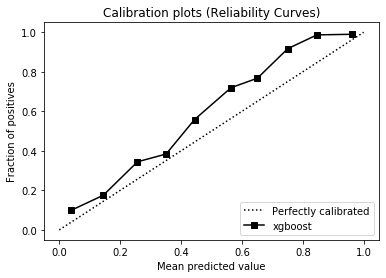

<Figure size 432x288 with 0 Axes>

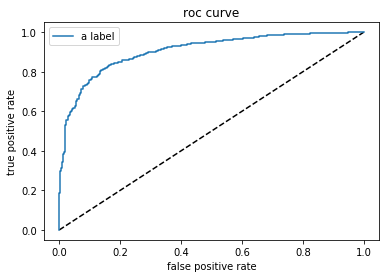

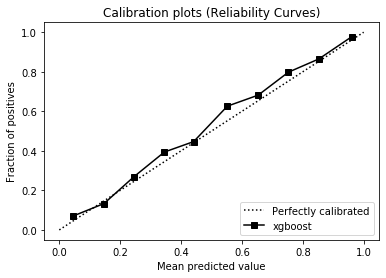

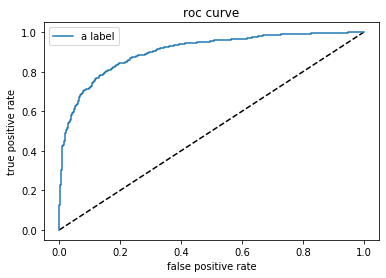

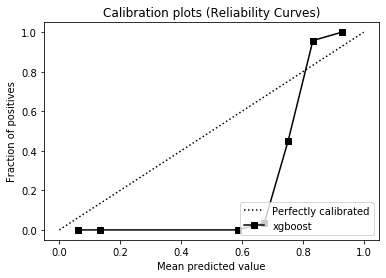

<Figure size 432x288 with 0 Axes>

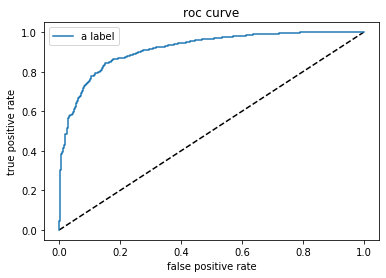

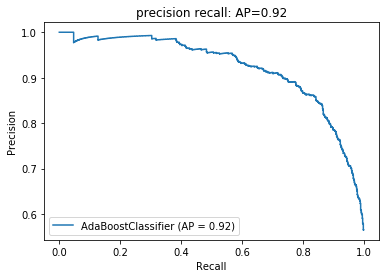

In [6]:
from mlrun import run_local, NewTask, mlconf

outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {"params":
         { "model_pkg_class" : model,
           "label_column"    : "labels",
          "plots_dest"       : "ppp",
           "models_dest"     : f'multi-models/{model}'}})
    
    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 2})

    if "LogisticRegression" in model:
        # use liblinear for small test set
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        # set max estimators below default, use weird learning rate
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 1.2
                                   })
    
    name = model.replace('.', '_')
    output = run_local(
        NewTask(**task_copy),
        handler=train_model,
        name=name,
        inputs={
            "dataset"  : DATA_URL
        })
    outputs.append({name: output.outputs})

In [7]:
outputs

[{'sklearn_ensemble_RandomForestClassifier': {'test-accuracy': 0.8262857142857143,
   'test-error': 0.1737142857142857,
   'rocauc': 0.9061243876397438,
   'brier_score': 0.15160265042374868,
   'f1-score': 0.8244803695150117,
   'precision_score': 0.8707317073170732,
   'recall_score': 0.7828947368421053,
   'test_set': 'store://default/sklearn_ensemble_RandomForestClassifier_test_set#f27fbfe88c6046a4a433f81d309a9a1b',
   'calibration curve': '/User/artifacts/ppp/calibration curve.html',
   'confusion-matrix-normalized': '/User/artifacts/ppp/confusion-matrix-normalized.html',
   'feature-importances': '/User/artifacts/ppp/feature-importances.html',
   'roc-binary': '/User/artifacts/ppp/roc-binary.html',
   'precision-recall-binary': '/User/artifacts/ppp/precision-recall-binary.html',
   'feature-importances-tbl': '/User/artifacts/ppp/precision-recall-binary.csv',
   'model': 'store://default/sklearn_ensemble_RandomForestClassifier_model#f27fbfe88c6046a4a433f81d309a9a1b'}},
 {'sklearn_

### run remotely

In [8]:
from mlutils import create_function

fn_params = {
    "name"            : "sklearn_classifier",
    "project"         : "functions",
    "default_handler" : "train_model",
    "desc"            : "train any classifier using scikit-learn's API",
    "categories"      : ["ml", "training"],
    "labels"          : {"author": "yjb", "framework": "sklearn"},
    "kind"            : "job",
    "image"           : "yjbds/ml-models",
    "tag"             : mlconf.images_tag,
}

In [9]:
fn = create_function(fn_params, path='.')

[mlrun] 2020-05-31 16:17:11,045 function spec saved to path: ./function.yaml


In [ ]:
outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {"params":
         {"model_pkg_class":model, 
          "label_column" : "labels",
          "models_dest" : f'sklearn/{model}'}})

    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 2})

    if "LogisticRegression" in model:
        # use liblinear for small test set
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        # set max estimators below default, use weird learning rate
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 1.2})

    name = model.replace('.', '_')
    fn.run(
        NewTask(**task_copy),
        name=name,
        inputs={
            "dataset"  : DATA_URL
        })
    outputs.append({name: output.outputs})

[mlrun] 2020-05-31 16:17:11,062 starting run sklearn_ensemble_RandomForestClassifier uid=a6efba304f734592bf3310622715f036  -> http://mlrun-api:8080
[mlrun] 2020-05-31 16:17:11,195 Job is running in the background, pod: sklearn-ensemble-randomforestclassifier-pkfd5


## tests

In [ ]:
from os import path

In [ ]:
df = pd.read_parquet(path.join(mlconf.artifact_path,'test_set.parquet'))
labels = df.pop('labels')

In [ ]:
adamodel = load(open(
    path.join(mlconf.artifact_path,
    'multi-models/sklearn.ensemble.AdaBoostClassifier/model.pkl'), 'rb'))
logregmodel = load(open(
    path.join(mlconf.artifact_path, 
    'multi-models/sklearn.linear_model.LogisticRegression/model.pkl'), 'rb'))
rfmodel = load(open(path.join(
    mlconf.artifact_path, 
    'multi-models/sklearn.ensemble.RandomForestClassifier/model.pkl'), 'rb'))

In [ ]:
print(adamodel)
print("row error\n", labels[labels!=np.argmax(adamodel.predict_proba(df), axis=1)], "\n")
print(logregmodel)
print("row error\n", labels[labels!=np.argmax(logregmodel.predict_proba(df), axis=1)], "\n")
print(rfmodel)
print("row error\n", labels[labels!=np.argmax(rfmodel.predict_proba(df), axis=1)], "\n")

In [ ]:
adamodel.feature_importances_